# Assignment 2: MNIST classification using a feedforward NN

In [341]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
import torchvision
import torchvision.transforms as transforms

In [342]:
import os

In [343]:
os.path

<module 'posixpath' from '/home/irtaza/miniconda3/lib/python3.8/posixpath.py'>

In [344]:

# Device configuration
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [345]:
trainset = torchvision.datasets.MNIST(root="./data",train=True, download=True)

In [346]:
trainset.data.float().mean()/255, trainset.data.float().std()/255, trainset.data.max(), trainset.data.min()

(tensor(0.1307),
 tensor(0.3081),
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8))

A bit wasteful but this is the moment information we will need to standardize the distribution (mean 0, var 1) after scaling it to [0,1). Just plagiarizing the instruction manual here: using torchvision.transforms to compose the minmax scaling and the standardization procedure:

In [362]:
class ReshapeTransform:  # a custom tranformer to flatten mnist image matrices
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return t.reshape(img, self.new_size)

transform = tv.transforms.Compose(
    [transforms.ToTensor()
     ,transforms.Normalize((trainset.data.float().mean()/255), (trainset.data.float().std()/255))
    ,transforms.Lambda(lambd=lambda x: x.flatten())]) # ooor just use a lambda function, ++brownie points for brevity

In [363]:


trainset = torchvision.datasets.MNIST(root="./data",train=True, download=True, transform=transform)
trainloader = t.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = t.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


In [364]:
trainset  # for some reason it doesn't register anything here... I was quite confused

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066047430038452, std=0.30810779333114624)
               Lambda()
           )

In [370]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.shape  ### but look the lambda transform is applied. Lazy evaluation is a bit weird

torch.Size([100, 784])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


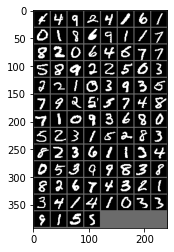

In [377]:
# show images: unsuccessful T_T => resolved
plt.imshow(np.transpose((torchvision.utils.make_grid(images.reshape(-1, 1,28,28))[:50]*255*0.3081+0.1301/0.3081).numpy(), (1,2,0)))

Update: the fact that I wasn't seeing anything was indicative of the underlying issue with the normalization/other transformations that were being applied that were messing with the tensor data. Now the images are visible. Issue resolved? Yes

Anyway, moving on... to the actual training and settling with matrices and numbers to let me know if the training was of any use...

>*The output should be a 10-way softmax layer to predict the digit label.*


In [356]:
import torch.nn as nn
import torch.nn.functional as F

# initialize the network architechture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        # feedforward with n=? hidden layers
        
        self.fc1 = nn.Linear(784, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
    
        return x


net = Net().to(device)
net

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

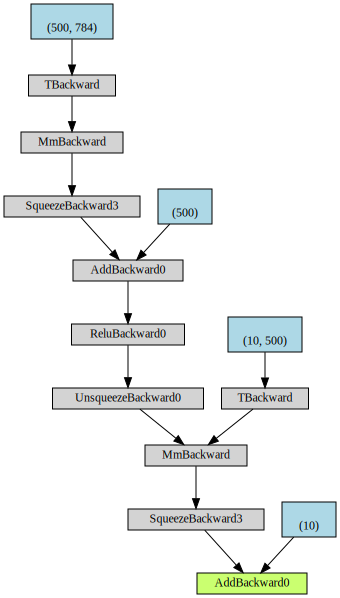

In [357]:
x = t.randn(784)
make_dot(Net().forward(x)) # visualize the architechture

In [358]:
import torch.optim as optim  # get an optimizer of choice

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [361]:
## train
epochs=5
total_step=len(trainloader)
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

print('Finished Training')

Epoch [1/5], Step [100/600], Loss: 0.0281
Epoch [1/5], Step [200/600], Loss: 0.0366
Epoch [1/5], Step [300/600], Loss: 0.0099
Epoch [1/5], Step [400/600], Loss: 0.0159
Epoch [1/5], Step [500/600], Loss: 0.0246
Epoch [1/5], Step [600/600], Loss: 0.0242
Epoch [2/5], Step [100/600], Loss: 0.0078
Epoch [2/5], Step [200/600], Loss: 0.0234
Epoch [2/5], Step [300/600], Loss: 0.0242
Epoch [2/5], Step [400/600], Loss: 0.0381
Epoch [2/5], Step [500/600], Loss: 0.0176
Epoch [2/5], Step [600/600], Loss: 0.0434
Epoch [3/5], Step [100/600], Loss: 0.0290
Epoch [3/5], Step [200/600], Loss: 0.0230
Epoch [3/5], Step [300/600], Loss: 0.0114
Epoch [3/5], Step [400/600], Loss: 0.0100
Epoch [3/5], Step [500/600], Loss: 0.0203
Epoch [3/5], Step [600/600], Loss: 0.0653
Epoch [4/5], Step [100/600], Loss: 0.0143


KeyboardInterrupt: 

In [360]:
with t.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = net(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 97.84 %
